In [20]:
import geopandas as gpd
gpd.__version__
import pandas as pd

In [2]:
path = './buildings/samples.geojson'
path_building = './buildings/samples_bld.geojson'
df = gpd.read_file(path)
df.head()

,geometry
0,"POLYGON ((724380.00000 1355444.99000, 724380.0..."
1,"POLYGON ((724880.05695 1355444.99000, 724880.0..."
2,"POLYGON ((725380.11390 1355444.99000, 725380.1..."
3,"POLYGON ((725880.17084 1355444.99000, 725880.1..."
4,"POLYGON ((726380.22779 1355444.99000, 726380.2..."


<Axes: >

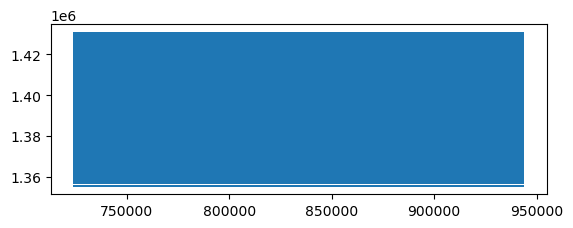

In [3]:
tmp = df.set_crs(3443, allow_override=True)
tmp.plot()

<Axes: >

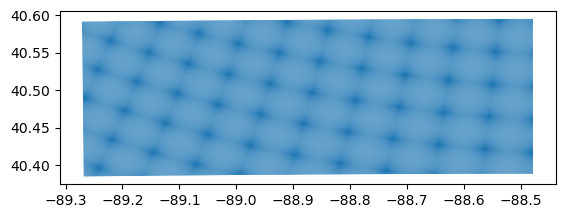

In [4]:
tmp2 = tmp.to_crs(4326)
tmp2.plot()

/Users/ridhaalkhabaz/opt/anaconda3/envs/conversat/lib/python3.9/site-packages/geopandas/plotting.py:718: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

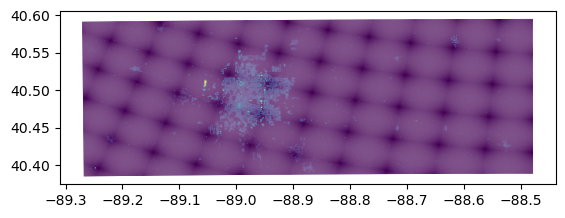

In [10]:
blds = gpd.read_file(path_building).set_crs(3443, allow_override=True)
blds = blds.to_crs(4326)
blds.plot(column='area')

In [11]:
blds.describe()

,id,FID,area
count,66000.00000,66000.000000,66000.000000
mean,32999.50000,1.010379,224.234668
std,19052.70322,4.174496,904.150804
min,0.00000,0.000000,0.000000
25%,16499.75000,0.000000,0.000000
50%,32999.50000,0.000000,0.000000
75%,49499.25000,0.000000,0.000000
max,65999.00000,59.000000,23224.885451


In [19]:
blds[blds['area']>23224.0]

,id,FID,area,geometry
38399,38399,1.0,23224.885450,"POLYGON ((-89.05386 40.50625, -89.05388 40.507..."
38839,38839,1.0,23224.885451,"POLYGON ((-89.05388 40.50763, -89.05389 40.509..."
39279,39279,1.0,23224.885450,"POLYGON ((-89.05389 40.50901, -89.05391 40.510..."
39719,39719,1.0,23224.885451,"POLYGON ((-89.05391 40.51039, -89.05392 40.511..."


In [21]:
df = pd.read_csv('./buildings/centers.csv')

In [22]:
df.head()

,Unnamed: 0,centroid,x,y
0,0,POINT (-89.26708652847677 40.38544918825039),-89.267087,40.385449
1,1,POINT (-89.26529170949608 40.38546366787838),-89.265292,40.385464
2,2,POINT (-89.26349688921479 40.38547811965417),-89.263497,40.385478
3,3,POINT (-89.26170206763534 40.38549254357772),-89.261702,40.385493
4,4,POINT (-89.25990724476026 40.38550693964897),-89.259907,40.385507


In [23]:
df.iloc[39719]

Unnamed: 0                                           39719
centroid      POINT (-89.05482058820398 40.51107822324394)
x                                               -89.054821
y                                                40.511078
Name: 39719, dtype: object

In [27]:
blds.iloc[39719]

id                                                      39719
FID                                                       1.0
area                                             23224.885451
geometry    POLYGON ((-89.05390830917717 40.51039011138188...
Name: 39719, dtype: object